## Dogs vs Cats - with augmentation

In [7]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg
import random
from shutil import copyfile

In [ ]:
!wget --no-check-certificate \
  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
  -O /content/cats_and_dogs_filtered.zip

--2021-10-09 05:08:46--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.189.128, 108.177.97.128, 108.177.125.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.189.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/content/cats_and_dogs_filtered.zip’

/content/cats_and_d 100%[===================>]  65.43M  20.1MB/s    in 3.3s    

2021-10-09 05:08:51 (20.1 MB/s) - ‘/content/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [ ]:
# content -> cats_and_dogs_filtered -> train -> cats, dogs
# content -> cats_and_dogs_filtered -> valid -> cats, dogs

import os
import zipfile

local_zip = '/content/cats_and_dogs_filtered.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
base_dir = '/content/cats_and_dogs_filtered'

train_dir = os.path.join(base_dir, 'train')
valid_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat/dog pictures
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat/dog pictures
valid_cats_dir = os.path.join(valid_dir, 'cats')
valid_dogs_dir = os.path.join(valid_dir, 'dogs')

In [ ]:
train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

print(train_cat_fnames[:10])
print(train_dog_fnames[:10])

['cat.691.jpg', 'cat.616.jpg', 'cat.890.jpg', 'cat.950.jpg', 'cat.169.jpg', 'cat.172.jpg', 'cat.180.jpg', 'cat.511.jpg', 'cat.285.jpg', 'cat.847.jpg']
['dog.624.jpg', 'dog.105.jpg', 'dog.896.jpg', 'dog.194.jpg', 'dog.233.jpg', 'dog.602.jpg', 'dog.440.jpg', 'dog.238.jpg', 'dog.836.jpg', 'dog.331.jpg']


In [ ]:
print('total training cat images :', len(os.listdir(train_cats_dir)))
print('total training dog images :', len(os.listdir(train_dogs_dir)))

print('total validation cat images :', len(os.listdir(valid_cats_dir)))
print('total validation dog images :', len(os.listdir(valid_dogs_dir)))

total training cat images : 1000
total training dog images : 1000
total validation cat images : 500
total validation dog images : 500


In [ ]:
IMG_HEIGHT = 150        
IMG_WIDTH = 150
CHANNELS = 3
NUM_CLASSES = 1

In [ ]:
model = Sequential([
    layers.InputLayer(input_shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS)),
    layers.Conv2D(16, (3,3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(NUM_CLASSES, activation='sigmoid')
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 18496)             0

In [ ]:
optimizer   = tf.keras.optimizers.RMSprop(learning_rate=0.001)
loss        = tf.keras.losses.BinaryCrossentropy()
metrics     = ['accuracy']

In [ ]:
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255.,
                                  rotation_range = 40,
                                  width_shift_range = 0.2,
                                  height_shift_range = 0.2,
                                  shear_range = 0.2,
                                  zoom_range = 0.2,
                                  horizontal_flip = True,
                                  fill_mode = 'nearest')        

train_generator = train_datagen.flow_from_directory(
                          train_dir,   
                          target_size = (IMG_HEIGHT, IMG_WIDTH),       # same as input image size
                          batch_size = 20,             
                          seed = 20,                      
                          class_mode = 'binary')

Found 2000 images belonging to 2 classes.


In [ ]:
valid_datagen = ImageDataGenerator(rescale = 1./255.)

valid_generator = valid_datagen.flow_from_directory(
                          valid_dir, 
                          target_size = (IMG_HEIGHT, IMG_WIDTH),
                          batch_size = 20,
                          seed = 20,
                          class_mode = 'binary')

Found 1000 images belonging to 2 classes.


In [ ]:
early_stopping    = EarlyStopping(monitor='val_accuracy', patience=10)
reduce_lr         = ReduceLROnPlateau(monitor='val_accuracy', patience=10, min_lr=0.001, mode='min', verbose=1)
model_checkpoint  = ModelCheckpoint(monitor='val_accuracy', filepath='./best_model.h5', save_best_only=True)

In [ ]:
EPOCHS = 70
CALLBACKS = [early_stopping, reduce_lr, model_checkpoint]

In [ ]:
history = model.fit(train_generator,
                  # steps_per_epoch = 100,                          # steps_per_epoch = total training records / batch size = 2000/20
                    validation_data = valid_generator,
                  # validation_steps = 50,                          # validation_steps = total validation records / batch size = 1000/20
                    verbose = 1,
                    epochs = EPOCHS,
                    callbacks = CALLBACKS)

Epoch 1/70
100/100 [==============================] - 21s 203ms/step - loss: 0.9080 - accuracy: 0.5070 - val_loss: 0.7282 - val_accuracy: 0.5010
Epoch 2/70
100/100 [==============================] - 20s 201ms/step - loss: 0.7028 - accuracy: 0.5595 - val_loss: 0.6805 - val_accuracy: 0.5360
Epoch 3/70
100/100 [==============================] - 20s 200ms/step - loss: 0.6894 - accuracy: 0.5915 - val_loss: 0.6124 - val_accuracy: 0.6640
Epoch 4/70
100/100 [==============================] - 20s 202ms/step - loss: 0.6571 - accuracy: 0.6285 - val_loss: 0.6052 - val_accuracy: 0.6750
Epoch 5/70
100/100 [==============================] - 20s 200ms/step - loss: 0.6307 - accuracy: 0.6425 - val_loss: 0.5886 - val_accuracy: 0.6670
Epoch 6/70
100/100 [==============================] - 20s 200ms/step - loss: 0.6295 - accuracy: 0.6590 - val_loss: 0.5865 - val_accuracy: 0.6760
Epoch 7/70
100/100 [==============================] - 20s 201ms/step - loss: 0.6332 - accuracy: 0.6580 - val_loss: 0.5841 - val_ac

In [ ]:
model.evaluate(valid_generator)

50/50 [==============================] - 3s 69ms/step - loss: 0.4710 - accuracy: 0.7750


[0.4709985554218292, 0.7749999761581421]

<Figure size 432x288 with 0 Axes>

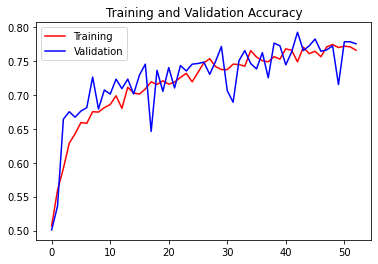

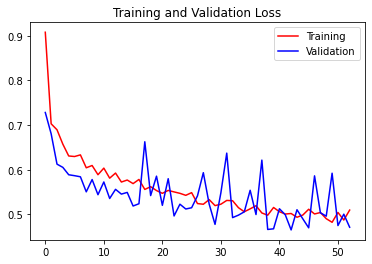

<Figure size 432x288 with 0 Axes>

In [ ]:
acc      = history.history['accuracy']
val_acc  = history.history['val_accuracy']

epochs   = range(len(acc))

plt.plot(epochs, acc, 'r', label = 'Training')
plt.plot(epochs, val_acc, 'b', label = 'Validation')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.figure()

loss     = history.history['loss']
val_loss = history.history['val_loss']

epochs   = range(len(loss))

plt.plot(epochs, loss, 'r', label = 'Training')
plt.plot(epochs, val_loss, 'b', label = 'Validation')
plt.title('Training and Validation Loss')
plt.legend()
plt.figure()

## Horse vs Human - with augmentation

In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip \
    -O /content/horse-or-human.zip

!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip \
    -O /content/validation-horse-or-human.zip

--2021-10-09 06:13:23--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.97.128, 108.177.125.128, 142.250.157.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.97.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 149574867 (143M) [application/zip]
Saving to: ‘/content/horse-or-human.zip’

/content/horse-or-h 100%[===================>] 142.65M  29.0MB/s    in 4.9s    

2021-10-09 06:13:28 (29.0 MB/s) - ‘/content/horse-or-human.zip’ saved [149574867/149574867]

--2021-10-09 06:13:28--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.97.128, 108.177.125.128, 142.250.157.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.97.128|:443... connected.
HTTP request sent, awaiting response... 200 O

In [ ]:
import os
import zipfile

local_zip = '/content/horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/horse-or-human')
local_zip = '/content/validation-horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/validation-horse-or-human')
zip_ref.close()

# Directory with our training horse pictures
train_horse_dir = os.path.join('/content/horse-or-human/horses')

# Directory with our training human pictures
train_human_dir = os.path.join('/content/horse-or-human/humans')

# Directory with our validation horse pictures
valid_horse_dir = os.path.join('/content/validation-horse-or-human/horses')

# Directory with our validation human pictures
valid_human_dir = os.path.join('/content/validation-horse-or-human/humans')

In [ ]:
IMG_HEIGHT = 300        
IMG_WIDTH = 300
CHANNELS = 3
NUM_CLASSES = 1

In [ ]:
model = Sequential([
    layers.InputLayer(input_shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS)),
    layers.Conv2D(16, (3,3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(NUM_CLASSES, activation='sigmoid')
])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 298, 298, 16)      448       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 149, 149, 16)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 147, 147, 32)      4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 71, 71, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 35, 35, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 33, 33, 64)       

In [ ]:
optimizer   = tf.keras.optimizers.RMSprop(learning_rate=1e-4)     # 0.0001
loss        = tf.keras.losses.BinaryCrossentropy()
metrics     = ['accuracy']

In [ ]:
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

TRAIN_DIR = '/content/horse-or-human'

train_datagen = ImageDataGenerator(rescale = 1./255.,
                                  rotation_range = 40,
                                  width_shift_range = 0.2,
                                  height_shift_range = 0.2,
                                  shear_range = 0.2,
                                  zoom_range = 0.2,
                                  horizontal_flip = True,
                                  fill_mode = 'nearest')     

train_generator = train_datagen.flow_from_directory(
                                  TRAIN_DIR,   
                                  target_size = (IMG_HEIGHT, IMG_WIDTH),       # same as input image size
                                  batch_size = 128,             
                                  seed = 20,                      
                                  class_mode = 'binary')

Found 1027 images belonging to 2 classes.


In [ ]:
VALID_DIR = '/content/validation-horse-or-human'

valid_datagen = ImageDataGenerator(rescale = 1./255.)

valid_generator = valid_datagen.flow_from_directory(
                                  VALID_DIR, 
                                  target_size = (IMG_HEIGHT, IMG_WIDTH),
                                  batch_size = 32,
                                  seed = 20,
                                  class_mode = 'binary')

Found 256 images belonging to 2 classes.


In [ ]:
early_stopping    = EarlyStopping(monitor='val_loss', patience=10)
reduce_lr         = ReduceLROnPlateau(monitor='val_loss', patience=10, min_lr=0.001, mode='min', verbose=1)
model_checkpoint  = ModelCheckpoint(monitor='val_loss', filepath='./best_model.h5', save_best_only=True)

In [ ]:
EPOCHS = 50
CALLBACKS = [early_stopping, reduce_lr, model_checkpoint]

In [ ]:
history = model.fit(train_generator,
                  # steps_per_epoch = 8,                          # steps_per_epoch = total training records / batch size = 1027/128
                    validation_data = valid_generator,
                  # validation_steps = 8,                          # validation_steps = total validation records / batch size = 256/32
                    verbose = 1,
                    epochs = EPOCHS,
                    callbacks = CALLBACKS)

Epoch 1/50
9/9 [==============================] - 30s 3s/step - loss: 0.6967 - accuracy: 0.5287 - val_loss: 0.6699 - val_accuracy: 0.6719
Epoch 2/50
9/9 [==============================] - 27s 3s/step - loss: 0.6765 - accuracy: 0.6475 - val_loss: 0.6866 - val_accuracy: 0.5000
Epoch 3/50
9/9 [==============================] - 27s 3s/step - loss: 0.6618 - accuracy: 0.6212 - val_loss: 0.6907 - val_accuracy: 0.5000
Epoch 4/50
9/9 [==============================] - 27s 3s/step - loss: 0.6441 - accuracy: 0.6475 - val_loss: 0.5633 - val_accuracy: 0.7656
Epoch 5/50
9/9 [==============================] - 27s 3s/step - loss: 0.6050 - accuracy: 0.7167 - val_loss: 0.5398 - val_accuracy: 0.7461
Epoch 6/50
9/9 [==============================] - 27s 3s/step - loss: 0.6064 - accuracy: 0.6796 - val_loss: 0.6349 - val_accuracy: 0.5898
Epoch 7/50
9/9 [==============================] - 26s 3s/step - loss: 0.5488 - accuracy: 0.7517 - val_loss: 0.7094 - val_accuracy: 0.5859
Epoch 8/50
9/9 [==================

In [ ]:
model.evaluate(valid_generator)

8/8 [==============================] - 1s 142ms/step - loss: 1.2538 - accuracy: 0.6445


[1.25377357006073, 0.64453125]

<Figure size 432x288 with 0 Axes>

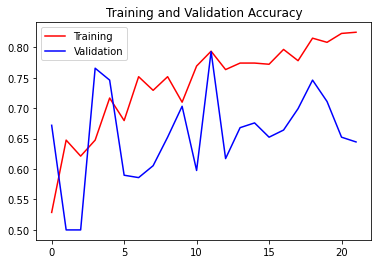

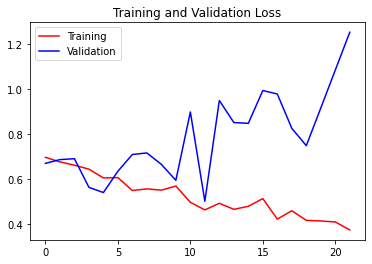

<Figure size 432x288 with 0 Axes>

In [ ]:
acc      = history.history['accuracy']
val_acc  = history.history['val_accuracy']

epochs   = range(len(acc))

plt.plot(epochs, acc, 'r', label = 'Training')
plt.plot(epochs, val_acc, 'b', label = 'Validation')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.figure()

loss     = history.history['loss']
val_loss = history.history['val_loss']

epochs   = range(len(loss))

plt.plot(epochs, loss, 'r', label = 'Training')
plt.plot(epochs, val_loss, 'b', label = 'Validation')
plt.title('Training and Validation Loss')
plt.legend()
plt.figure()

## Dogs vs Cats Full Dataset - with augmentation

**Exercise 6**

In this exercise you will train a CNN on the FULL Cats-v-dogs dataset. This will require you doing a lot of data preprocessing because the dataset isn't split into training and validation for you.

In [1]:
!wget --no-check-certificate \
    "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip" \
    -O "/content/cats-and-dogs.zip"

--2021-11-09 08:28:50--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.200.60.129, 2600:1407:3c00:108c::e59, 2600:1407:3c00:10a2::e59
Connecting to download.microsoft.com (download.microsoft.com)|23.200.60.129|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824894548 (787M) [application/octet-stream]
Saving to: ‘/content/cats-and-dogs.zip’

/content/cats-and-d 100%[===================>] 786.68M   144MB/s    in 5.6s    

2021-11-09 08:28:56 (141 MB/s) - ‘/content/cats-and-dogs.zip’ saved [824894548/824894548]



In [2]:
import os
import zipfile

local_zip = '/content/cats-and-dogs.zip'
zip_ref   = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [3]:
# content -> PetImages -> cats, dogs
# training and validation directory not given separately

print(len(os.listdir('/content/PetImages/Cat/')))
print(len(os.listdir('/content/PetImages/Dog/')))

12501
12501


In [4]:
try:
    os.mkdir('/content/cats-v-dogs')
    os.mkdir('/content/cats-v-dogs/training')
    os.mkdir('/content/cats-v-dogs/testing')
    os.mkdir('/content/cats-v-dogs/training/cats')
    os.mkdir('/content/cats-v-dogs/training/dogs')
    os.mkdir('/content/cats-v-dogs/testing/cats')
    os.mkdir('/content/cats-v-dogs/testing/dogs')
except OSError:
    pass

In [5]:
# it will split the directory and separate train and validation images
# 90% images will be copied to training folder
# 10% to validation

def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    files = []
    for filename in os.listdir(SOURCE):
        file = SOURCE + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " is zero length, so ignoring.")

    training_length = int(len(files) * SPLIT_SIZE)
    testing_length = int(len(files) - training_length)
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:training_length]
    testing_set = shuffled_set[-testing_length:]

    for filename in training_set:
        this_file = SOURCE + filename
        destination = TRAINING + filename
        copyfile(this_file, destination)

    for filename in testing_set:
        this_file = SOURCE + filename
        destination = TESTING + filename
        copyfile(this_file, destination)

In [8]:
CAT_SOURCE_DIR = "/content/PetImages/Cat/"
TRAINING_CATS_DIR = "/content/cats-v-dogs/training/cats/"
TESTING_CATS_DIR = "/content/cats-v-dogs/testing/cats/"
DOG_SOURCE_DIR = "/content/PetImages/Dog/"
TRAINING_DOGS_DIR = "/content/cats-v-dogs/training/dogs/"
TESTING_DOGS_DIR = "/content/cats-v-dogs/testing/dogs/"

split_size = .9
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, TESTING_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, TESTING_DOGS_DIR, split_size)

666.jpg is zero length, so ignoring.
11702.jpg is zero length, so ignoring.


In [9]:
print(len(os.listdir('/content/cats-v-dogs/training/cats/')))
print(len(os.listdir('/content/cats-v-dogs/training/dogs/')))
print(len(os.listdir('/content/cats-v-dogs/testing/cats/')))
print(len(os.listdir('/content/cats-v-dogs/testing/dogs/')))

11250
11250
1250
1250


In [10]:
IMG_HEIGHT = 150        
IMG_WIDTH = 150
CHANNELS = 3
NUM_CLASSES = 1

In [11]:
model = Sequential([
    layers.InputLayer(input_shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS)),
    layers.Conv2D(16, (3,3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(NUM_CLASSES, activation='sigmoid')
])

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 18496)             0

In [13]:
optimizer   = tf.keras.optimizers.RMSprop(learning_rate=0.001)
loss        = tf.keras.losses.BinaryCrossentropy()
metrics     = ['accuracy']

In [14]:
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)

In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

TRAIN_DIR = '/content/cats-v-dogs/training/'

train_datagen = ImageDataGenerator(rescale = 1./255.,
                                  rotation_range = 40,
                                  width_shift_range = 0.2,
                                  height_shift_range = 0.2,
                                  shear_range = 0.2,
                                  zoom_range = 0.2,
                                  horizontal_flip = True,
                                  fill_mode = 'nearest')       

train_generator = train_datagen.flow_from_directory(
                                  TRAIN_DIR,   
                                  target_size = (IMG_HEIGHT, IMG_WIDTH),       # same as input image size
                                  batch_size = 100,             
                                  seed = 20,                      
                                  class_mode = 'binary')

Found 22498 images belonging to 2 classes.


In [16]:
VALID_DIR = '/content/cats-v-dogs/testing/'

valid_datagen = ImageDataGenerator(rescale = 1./255.)

valid_generator = valid_datagen.flow_from_directory(
                          VALID_DIR, 
                          target_size = (IMG_HEIGHT, IMG_WIDTH),
                          batch_size = 100,
                          seed = 20,
                          class_mode = 'binary')

Found 2500 images belonging to 2 classes.


In [ ]:
early_stopping    = EarlyStopping(monitor='val_loss', patience=7)
reduce_lr         = ReduceLROnPlateau(monitor='val_loss', patience=7, min_lr=0.001, mode='min', verbose=1)
model_checkpoint  = ModelCheckpoint(monitor='val_loss', filepath='./best_model.h5', save_best_only=True)

In [ ]:
EPOCHS = 20
CALLBACKS = [early_stopping, reduce_lr, model_checkpoint]

In [ ]:
history = model.fit(train_generator,
                    validation_data = valid_generator,
                    verbose = 1,
                    epochs = EPOCHS,
                    callbacks = CALLBACKS)

Epoch 1/20
153/248 [=================>............] - ETA: 1:18 - loss: 0.7496 - accuracy: 0.5594

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

248/248 [==============================] - 229s 890ms/step - loss: 0.7274 - accuracy: 0.5774 - val_loss: 0.6449 - val_accuracy: 0.6486
Epoch 2/20
248/248 [==============================] - 218s 878ms/step - loss: 0.6260 - accuracy: 0.6523 - val_loss: 0.5515 - val_accuracy: 0.7134
Epoch 3/20
248/248 [==============================] - 217s 873ms/step - loss: 0.5793 - accuracy: 0.6933 - val_loss: 0.5461 - val_accuracy: 0.7080
Epoch 4/20
248/248 [==============================] - 212s 855ms/step - loss: 0.5478 - accuracy: 0.7213 - val_loss: 0.4867 - val_accuracy: 0.7690
Epoch 5/20
248/248 [==============================] - 209s 841ms/step - loss: 0.5304 - accuracy: 0.7319 - val_loss: 0.5204 - val_accuracy: 0.7450
Epoch 6/20
248/248 [==============================] - 208s 840ms/step - loss: 0.5160 - accuracy: 0.7454 - val_loss: 0.4738 - val_accuracy: 0.7667
Epoch 7/20
248/248 [==============================] - 209s 842ms/step - loss: 0.5014 - accuracy: 0.7539 - val_loss: 0.4462 - val_accura

In [ ]:
model.evaluate(valid_generator)

48/48 [==============================] - 15s 302ms/step - loss: 0.5475 - accuracy: 0.7993


[0.5475403666496277, 0.7992846369743347]

<Figure size 432x288 with 0 Axes>

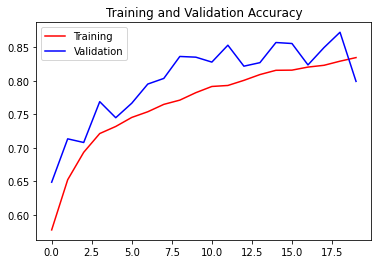

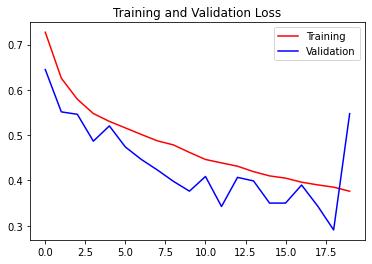

<Figure size 432x288 with 0 Axes>

In [ ]:
acc      = history.history['accuracy']
val_acc  = history.history['val_accuracy']

epochs   = range(len(acc))

plt.plot(epochs, acc, 'r', label = 'Training')
plt.plot(epochs, val_acc, 'b', label = 'Validation')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.figure()

loss     = history.history['loss']
val_loss = history.history['val_loss']

epochs   = range(len(loss))

plt.plot(epochs, loss, 'r', label = 'Training')
plt.plot(epochs, val_loss, 'b', label = 'Validation')
plt.title('Training and Validation Loss')
plt.legend()
plt.figure()

In [ ]:
from google.colab import files
from keras.preprocessing import image
uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(150, 150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  if classes[0]>0.5:
    print(fn + " is a dog")
  else:
    print(fn + " is a cat")

Saving best-girl-cat-names-1606245046.jpg to best-girl-cat-names-1606245046.jpg
[1.0741011e-29]
best-girl-cat-names-1606245046.jpg is a cat
